In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Changed metrics for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [ ]:
# 데이터셋 인스턴스 생성

data = pd.read_csv('https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv')

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


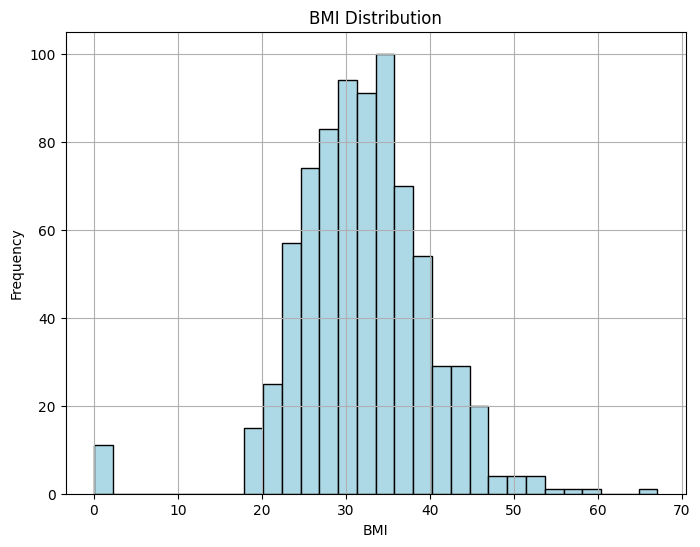

In [ ]:
# Target variable distribution (BMI)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
# Changed plotting to histogram for BMI
data.BMI.hist(bins=30, color='lightblue', edgecolor='black')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

In [ ]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
# Define feature and target columns for BMI regression
target_column = 'BMI'
# Exclude Outcome and BMI from features
feature_columns = data.columns.drop(['Outcome', 'BMI']).tolist()
print("Feature Columns:", feature_columns)
print("Target Column:", target_column)

Feature Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
Target Column: BMI


In [ ]:
# Preprocessing - No Label Encoding needed for numerical features
print("Diabetes dataset features are numerical. Skipping Label Encoding.")

Diabetes dataset features are numerical. Skipping Label Encoding.


In [ ]:
# Display data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Data Preparation for Dense Network (Regression)

In [ ]:
# 데이터와 타겟 분리 (BMI Regression)
X = data[feature_columns].values
y = data[target_column].values

In [ ]:
# Split the dataset into training and test sets first
# Removed stratify=y as it's regression
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (Fit on train, transform train and test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw) # Use transform only for test set

# Note: Target variable (BMI) is NOT scaled here, but scaling it might improve performance.
# If scaling y:
# y_scaler = StandardScaler()
# y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
# y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()
# Remember to use y_scaler.inverse_transform() for predictions later.

In [ ]:
# Print shapes to verify
print("Train features shape:", X_train.shape) # Should be (samples, 7)
print("Test features shape:", X_test.shape)
print("Train target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

Train features shape: (614, 7)
Test features shape: (154, 7)
Train target shape: (614,)
Test target shape: (154,)


In [ ]:
# Convert to PyTorch tensors
# Features remain float32
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Target needs to be float32 and reshaped for MSELoss
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [ ]:
# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Verify tensor shapes
print("Train features tensor shape:", X_train_tensor.shape)
print("Test features tensor shape:", X_test_tensor.shape)
print("Train target tensor shape:", y_train_tensor.shape) # Should be (samples, 1)
print("Test target tensor shape:", y_test_tensor.shape)

Train features tensor shape: torch.Size([614, 7])
Test features tensor shape: torch.Size([154, 7])
Train target tensor shape: torch.Size([614, 1])
Test target tensor shape: torch.Size([154, 1])


# 모델 정의 (Dense Network for Regression)

In [ ]:
# 모델 정의 (Dense Network for Regression - ReLU 분리)
class DiabetesDenseReg(nn.Module):
    def __init__(self):
        super(DiabetesDenseReg, self).__init__()
        # Linear 레이어만 정의
        self.fc1 = nn.Linear(7, 64)  # 7 input features (Outcome, BMI 제외)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)   # 1 output feature (BMI prediction)

    def forward(self, x):
        # forward 메서드 내에서 ReLU 적용
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) # 회귀 문제의 마지막 출력은 일반적으로 활성화 함수 없음
        return x

# Initialize the model
dense_model = DiabetesDenseReg()
print(dense_model)

DiabetesDenseReg(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


# 손실 함수 및 최적화 기법 정의 (Regression)

In [ ]:
# Use MSELoss for regression
criterion = nn.MSELoss()
optimizer = optim.Adam(dense_model.parameters(), lr=0.001)

# 모델 학습 (Dense Network for Regression)

In [ ]:
# Variables to store loss
dense_train_losses = []
dense_test_losses = [] # Store test loss as well
dense_test_predictions = []
dense_test_actuals = []

# Training loop
num_epochs = 100 # Regression might need more epochs
for epoch in range(num_epochs):
    dense_model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = dense_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    # Calculate average loss over an epoch
    epoch_train_loss = running_loss / len(train_dataloader.dataset)
    dense_train_losses.append(epoch_train_loss)

    # Evaluate on test data
    dense_model.eval()
    test_loss = 0.0
    epoch_test_preds = []
    epoch_test_actuals = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = dense_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            epoch_test_preds.extend(outputs.cpu().numpy().flatten()) # Flatten predictions
            epoch_test_actuals.extend(labels.cpu().numpy().flatten()) # Flatten actuals

    epoch_test_loss = test_loss / len(test_dataloader.dataset)
    dense_test_losses.append(epoch_test_loss)

    # Store predictions/actuals from the *last* epoch for final evaluation
    if epoch == num_epochs - 1:
        dense_test_predictions = np.array(epoch_test_preds)
        dense_test_actuals = np.array(epoch_test_actuals)

    if (epoch + 1) % 10 == 0: # Print every 10 epochs
      print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

print("Dense Network Regression Training complete.")

Epoch 10/100, Train Loss: 80.6796, Test Loss: 95.5897
Epoch 20/100, Train Loss: 57.4334, Test Loss: 79.5195
Epoch 30/100, Train Loss: 47.8076, Test Loss: 73.3793
Epoch 40/100, Train Loss: 42.1131, Test Loss: 68.6625
Epoch 50/100, Train Loss: 38.3969, Test Loss: 65.5874
Epoch 60/100, Train Loss: 36.1653, Test Loss: 62.8654
Epoch 70/100, Train Loss: 34.6853, Test Loss: 62.2518
Epoch 80/100, Train Loss: 33.7979, Test Loss: 61.3938
Epoch 90/100, Train Loss: 32.7750, Test Loss: 61.3551
Epoch 100/100, Train Loss: 32.0720, Test Loss: 60.8823
Dense Network Regression Training complete.


# 모델 평가 (Dense Network for Regression)

In [ ]:
# Evaluation using regression metrics from the last epoch's test predictions
mse = mean_squared_error(dense_test_actuals, dense_test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(dense_test_actuals, dense_test_predictions)
r2 = r2_score(dense_test_actuals, dense_test_predictions)

print("--- Dense Network Regression Evaluation Results ---")
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared (R²): {r2:.4f}')

--- Dense Network Regression Evaluation Results ---
Mean Squared Error (MSE): 60.8823
Root Mean Squared Error (RMSE): 7.8027
Mean Absolute Error (MAE): 5.3611
R-squared (R²): 0.1435


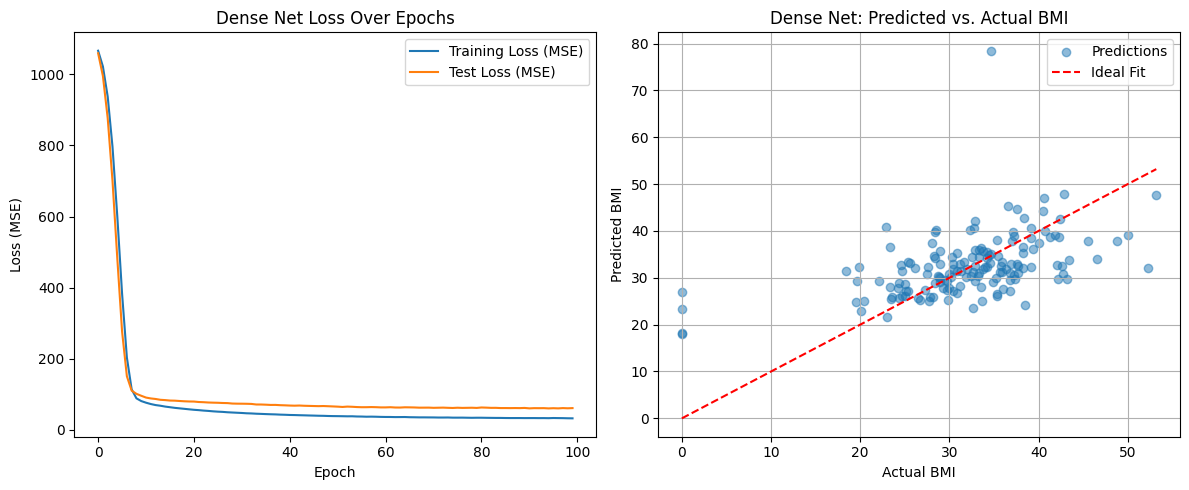

In [ ]:
# Plot the loss for Dense Network Regression
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(dense_train_losses, label='Training Loss (MSE)')
plt.plot(dense_test_losses, label='Test Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Dense Net Loss Over Epochs')
plt.legend()

# Plot Predicted vs Actual values
plt.subplot(1, 2, 2)
plt.scatter(dense_test_actuals, dense_test_predictions, alpha=0.5, label='Predictions')
plt.plot([min(dense_test_actuals), max(dense_test_actuals)], [min(dense_test_actuals), max(dense_test_actuals)], 'r--', label='Ideal Fit') # Line y=x
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Dense Net: Predicted vs. Actual BMI')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Data Preparation for 1D CNN (Regression)

In [ ]:
# Start again with original data for sequence processing
data_cnn = pd.read_csv('https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv')

# 데이터와 타겟 분리 (특성: Outcome, BMI 제외 / 타겟: BMI)
X_cnn = data_cnn[feature_columns].values # feature_columns already excludes Outcome & BMI
y_cnn = data_cnn[target_column].values

In [ ]:
# Standardize the features (using the whole dataset before splitting for sequence creation)
scaler_cnn = StandardScaler()
X_cnn_scaled = scaler_cnn.fit_transform(X_cnn)

In [ ]:
# Combine scaled features and target for sequence splitting
# Target y_cnn must be reshaped before hstack
data_array = np.hstack((X_cnn_scaled, y_cnn.reshape(-1, 1)))

In [ ]:
# Check shape (should be features + 1 target = 7 + 1 = 8 columns)
print("Combined data array shape:", data_array.shape)

Combined data array shape: (768, 8)


In [ ]:
# Split sequences function (Modified for regression)
def split_sequences_reg(sequences, n_steps):
    X, y = list(), list()
    n_features = sequences.shape[1] - 1 # Number of features (excluding target)
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix >= len(sequences): # Ensure target index is within bounds
            break
        # Input: sequence from i to end_ix (features only, index 0 to n_features-1)
        # Output: target BMI at end_ix (the step after the sequence ends, last column index)
        seq_x, seq_y = sequences[i:end_ix, :n_features], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Apply sequence transformation
n_steps = 5 # Define sequence length
X_seq, y_seq = split_sequences_reg(data_array, n_steps)

# Split the SEQUENCED dataset into training and test sets
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [ ]:
# Print shapes to verify sequenced data
print("Sequence Train features shape:", X_train_seq.shape) # (samples, steps, features)
print("Sequence Train target shape:", y_train_seq.shape)
print("Sequence Test features shape:", X_test_seq.shape)
print("Sequence Test target shape:", y_test_seq.shape)

Sequence Train features shape: (610, 5, 7)
Sequence Train target shape: (610,)
Sequence Test features shape: (153, 5, 7)
Sequence Test target shape: (153,)


In [ ]:
# Convert sequenced data to PyTorch tensors
X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
X_test_seq_tensor = torch.tensor(X_test_seq, dtype=torch.float32)

# Target needs to be float32 and reshaped
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).reshape(-1, 1)
y_test_seq_tensor = torch.tensor(y_test_seq, dtype=torch.float32).reshape(-1, 1)

# Create DataLoader for sequenced data
batch_size_cnn = 32
train_dataset_seq = TensorDataset(X_train_seq_tensor, y_train_seq_tensor)
train_dataloader_seq = DataLoader(train_dataset_seq, batch_size=batch_size_cnn, shuffle=True)

test_dataset_seq = TensorDataset(X_test_seq_tensor, y_test_seq_tensor)
test_dataloader_seq = DataLoader(test_dataset_seq, batch_size=batch_size_cnn, shuffle=False)

# 모델 정의 (1D CNN for Regression)

In [ ]:
# 모델 정의 (1D CNN for Regression - ReLU 분리)
class DiabetesCNNReg(nn.Module):
    def __init__(self, n_features=7, n_steps=5, n_outputs=1):
        super(DiabetesCNNReg, self).__init__()
        self.n_steps = n_steps
        self.n_features = n_features

        # Convolutional 레이어 정의
        self.conv1 = nn.Conv1d(n_features, 16, kernel_size=3, padding=1) # 입력 채널 = feature 수
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)

        # Fully Connected 레이어 정의
        self.fc1 = nn.Linear(32 * n_steps, 64)
        self.fc2 = nn.Linear(64, n_outputs) # 출력 크기 1 (BMI 예측)

    def forward(self, x):
        # Conv1d는 (batch, channels, seq_len) 입력을 기대
        # 학습 루프에서 permute(0, 2, 1)을 적용했다고 가정

        # Convolutional 레이어 통과 및 ReLU 적용
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        # Flatten 처리
        x = x.view(x.size(0), -1)

        # Fully Connected 레이어 통과 및 ReLU 적용
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) # 회귀 문제의 마지막 출력은 일반적으로 활성화 함수 없음
        return x

In [ ]:
# Initialize the CNN model, loss function, and optimizer
cnn_model = DiabetesCNNReg(n_features=X_train_seq.shape[2], n_steps=n_steps, n_outputs=1)
cnn_criterion = nn.MSELoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [ ]:
# Print the summary of the CNN model
# Input size should be (features, sequence_length)
summary(cnn_model, input_size=(X_train_seq.shape[2], n_steps))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 5]             352
            Conv1d-2                [-1, 32, 5]           1,568
            Linear-3                   [-1, 64]          10,304
            Linear-4                    [-1, 1]              65
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


# 모델 학습 (1D CNN for Regression)

In [ ]:
# Variables to store loss for CNN Regression
cnn_train_losses = []
cnn_test_losses = []
cnn_test_predictions = []
cnn_test_actuals = []

In [ ]:
# Training loop for CNN Regression
num_epochs_cnn = 100 # Adjust epochs if needed
for epoch in range(num_epochs_cnn):
    cnn_model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader_seq:
        # Permute input: (batch, seq_len, features) -> (batch, features, seq_len)
        inputs = inputs.permute(0, 2, 1)

        # Zero the parameter gradients
        cnn_optimizer.zero_grad()

        # Forward pass
        outputs = cnn_model(inputs)
        loss = cnn_criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        cnn_optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    # Calculate average loss over an epoch
    epoch_train_loss = running_loss / len(train_dataloader_seq.dataset)
    cnn_train_losses.append(epoch_train_loss)

    # Evaluate on test data
    cnn_model.eval()
    test_loss = 0.0
    epoch_test_preds_cnn = []
    epoch_test_actuals_cnn = []
    with torch.no_grad():
        for inputs, labels in test_dataloader_seq:
            # Permute input
            inputs = inputs.permute(0, 2, 1)

            outputs = cnn_model(inputs)
            loss = cnn_criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            epoch_test_preds_cnn.extend(outputs.cpu().numpy().flatten())
            epoch_test_actuals_cnn.extend(labels.cpu().numpy().flatten())

    epoch_test_loss = test_loss / len(test_dataloader_seq.dataset)
    cnn_test_losses.append(epoch_test_loss)

    # Store predictions/actuals from the *last* epoch for final evaluation
    if epoch == num_epochs_cnn - 1:
        cnn_test_predictions = np.array(epoch_test_preds_cnn)
        cnn_test_actuals = np.array(epoch_test_actuals_cnn)

    if (epoch + 1) % 10 == 0: # Print every 10 epochs
        print(f"CNN Epoch {epoch + 1}/{num_epochs_cnn}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

print("CNN Regression Training complete.")

CNN Epoch 10/100, Train Loss: 45.9455, Test Loss: 85.8829
CNN Epoch 20/100, Train Loss: 45.2744, Test Loss: 96.4717
CNN Epoch 30/100, Train Loss: 43.0370, Test Loss: 88.5523
CNN Epoch 40/100, Train Loss: 41.6858, Test Loss: 89.2384
CNN Epoch 50/100, Train Loss: 39.8350, Test Loss: 93.4800
CNN Epoch 60/100, Train Loss: 37.8164, Test Loss: 93.7610
CNN Epoch 70/100, Train Loss: 36.0860, Test Loss: 98.0582
CNN Epoch 80/100, Train Loss: 34.4278, Test Loss: 100.3235
CNN Epoch 90/100, Train Loss: 32.8441, Test Loss: 103.6434
CNN Epoch 100/100, Train Loss: 31.6304, Test Loss: 107.6104
CNN Regression Training complete.



--- CNN Regression Evaluation Results ---
Mean Squared Error (MSE): 107.6105
Root Mean Squared Error (RMSE): 10.3735
Mean Absolute Error (MAE): 8.2272
R-squared (R²): -0.5422


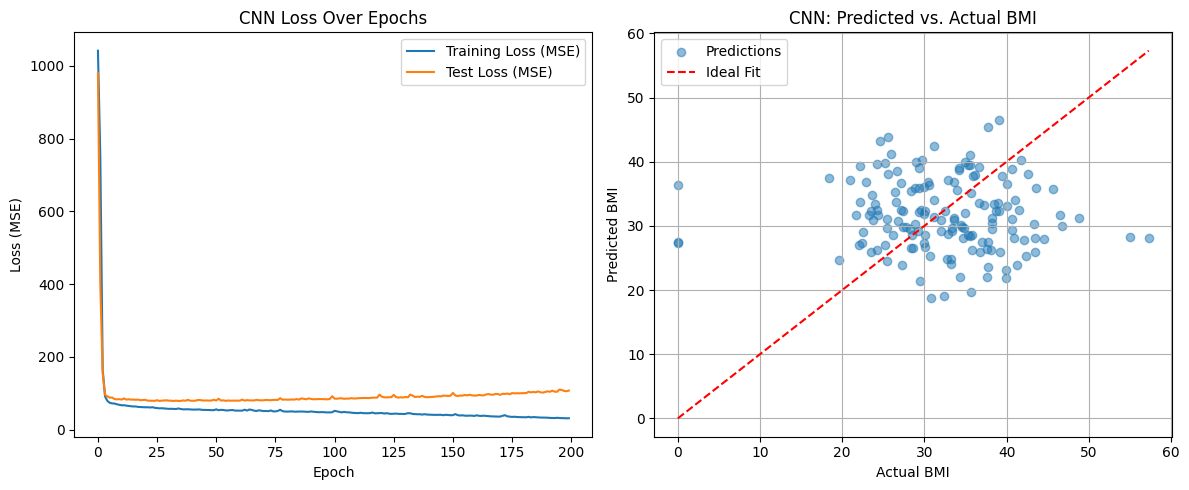

In [ ]:
cnn_mse = mean_squared_error(cnn_test_actuals, cnn_test_predictions)
cnn_rmse = np.sqrt(cnn_mse)
cnn_mae = mean_absolute_error(cnn_test_actuals, cnn_test_predictions)
cnn_r2 = r2_score(cnn_test_actuals, cnn_test_predictions)

# Print metrics for CNN
print("\n--- CNN Regression Evaluation Results ---")
print(f'Mean Squared Error (MSE): {cnn_mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {cnn_rmse:.4f}')
print(f'Mean Absolute Error (MAE): {cnn_mae:.4f}')
print(f'R-squared (R²): {cnn_r2:.4f}')

# Plot the loss and accuracy for CNN Regression
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(cnn_train_losses, label='Training Loss (MSE)')
plt.plot(cnn_test_losses, label='Test Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('CNN Loss Over Epochs')
plt.legend()

# Plot Predicted vs Actual values
plt.subplot(1, 2, 2)
plt.scatter(cnn_test_actuals, cnn_test_predictions, alpha=0.5, label='Predictions')
plt.plot([min(cnn_test_actuals), max(cnn_test_actuals)], [min(cnn_test_actuals), max(cnn_test_actuals)], 'r--', label='Ideal Fit')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('CNN: Predicted vs. Actual BMI')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()